In [1]:
import pennylane as qml
import numpy as np
import jax

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

dev = qml.device("default.qubit", wires=1)
H = 0.6 * qml.PauliZ(0) - 0.8 * qml.PauliY(0)


def qfunc(theta):
    qml.SpecialUnitary(theta, wires=0)
    return qml.expval(H)


circuit = qml.QNode(qfunc, dev, interface="jax", diff_method="parameter-shift")

theta = jnp.array([0.4, 0.2, -0.5])

In [3]:
unit_vector = np.array([0.0, 1.0, 0.0])


def central_diff_grad(theta, delta):
    plus_eval = circuit(theta + delta / 2 * unit_vector)
    minus_eval = circuit(theta - delta / 2 * unit_vector)
    return (plus_eval - minus_eval) / delta


delta = 0.75
print(f"Central difference: {central_diff_grad(theta, delta):.5f}")

Central difference: 0.42398


In [4]:
@jax.jit
@qml.qnode(dev, interface="jax")
def aux_circuit(theta, tau, sign):
    qml.SpecialUnitary(tau * theta, wires=0)
    # This corresponds to the parameter-shift evaluations of RY at 0
    qml.RY(-sign * np.pi / 2, wires=0)
    qml.SpecialUnitary((1 - tau) * theta, wires=0)
    return qml.expval(H)


def stochastic_parshift_grad(theta, num_samples):
    grad = 0
    splitting_times = np.random.random(size=num_samples)
    for tau in splitting_times:
        # Evaluate the two-term parameter-shift rule of the auxiliar circuit
        grad += aux_circuit(theta, tau, 1.0) - aux_circuit(theta, tau, -1.0)
    return grad / num_samples


num_samples = 10
print(f"Stochastic parameter-shift: {stochastic_parshift_grad(theta, num_samples):.5f}")

Stochastic parameter-shift: 0.34111


In [5]:
sun_grad = jax.grad(circuit)
print(f"Custom SU(N) gradient: {sun_grad(theta)[1]:.5f}")

Custom SU(N) gradient: 0.42609


In [6]:
autodiff_circuit = qml.QNode(qfunc, dev, interface="jax", diff_method="parameter-shift")
exact_grad = jax.grad(autodiff_circuit)(theta)[1]
print(f"Exact gradient: {exact_grad:.5f}")

Exact gradient: 0.42609


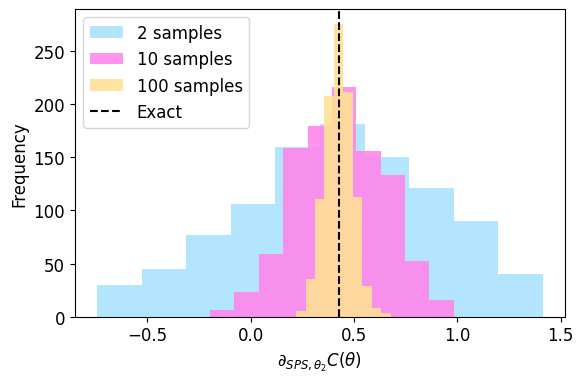

In [7]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 12})

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
colors = ["#ACE3FF", "#FF87EB", "#FFE096"]
for num_samples, color in zip([2, 10, 100], colors):
    grads = [stochastic_parshift_grad(theta, num_samples) for _ in range(1000)]
    ax.hist(grads, label=f"{num_samples} samples", alpha=0.9, color=color)
ylim = ax.get_ylim()
ax.plot([exact_grad] * 2, ylim, ls="--", c="k", label="Exact")
ax.set(xlabel=r"$\partial_{SPS,\theta_2}C(\theta)$", ylabel="Frequency", ylim=ylim)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [8]:
def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)


# The three building blocks on two qubits we will compare are:
operations = {
    ("Decomposition", "decomposition"): two_qubit_decomp,
    ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
    ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
}

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_22904/391022573.py:24: SyntaxWarning: invalid escape sequence '\m'
  ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,


In [9]:
num_wires = 6
wires = list(range(num_wires))
np.random.seed(62213)

# coefficients = np.random.randn(4**num_wires - 1)
# # Create the matrices for the entire Pauli basis
# basis = qml.ops.qubit.special_unitary.pauli_basis_matrices(num_wires)
# # Construct the Hamiltonian from the normal random coefficients and the basis
# H_matrix = qml.math.tensordot(coefficients, basis, axes=[[0], [0]])
# print(H_matrix.shape)
# H = qml.Hermitian(H_matrix, wires=wires)
# # Compute the ground state energy
# E_min = min(qml.eigvals(H))
# print(f"Ground state energy: {E_min:.5f}")

In [10]:
# from qiskit.circuit.library import QAOAAnsatz
# from qiskit.quantum_info import SparsePauliOp

# hamiltonian = SparsePauliOp.from_list([
#     ("IIZZ", 1), ("IIIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1),
# ])

# H_matrix = hamiltonian.to_matrix()
# H = qml.Hermitian(H_matrix, wires=wires)
# H = qml.prod(*[qml.PauliZ(i) for i in range(num_wires)])
# H = qml.Hermitian(-1 * H.matrix(), wires)

# Define the Hamiltonian
coeffs = []
obs = []

# Coupling constant (J) and transverse field strength (h)
J = 1.0
h = 0.5

# ZZ interactions
for i in range(num_wires):
    for j in range(i+1, num_wires):
        coeffs.append(-J)
        obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

# X interactions
for i in range(num_wires):
    coeffs.append(-h)
    obs.append(qml.PauliX(i))

# Create the Hamiltonian
H = qml.Hamiltonian(coeffs, obs)

E_min = min(qml.eigvals(H))

#print(qml.eigvals(H))
print(f"Ground state energy: {E_min:.5f}")

Ground state energy: -15.15012


/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/pennylane/ops/functions/eigvals.py:120: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [11]:
loc = 2
d = 4**loc - 1  # d = 15 for two-qubit operations
dev = qml.device("default.qubit", wires=num_wires)
# two blocks with two layers. Each layer contains three operations with d parameters
param_shape = (6, 2, 3, d)
init_params = np.zeros(param_shape, dtype=np.float64)


def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                #print("performing",  operation, "operations", " on ", wires_op, "params", params_op)
                operation(params_op, wires_op)
    return qml.expval(H)

qnode = qml.QNode(circuit, dev, interface="jax")
print(qml.draw(qnode)(init_params, qml.SpecialUnitary))

0: ─╭SpecialUnitary(M0)─────────────────────╭SpecialUnitary(M0)─╭SpecialUnitary(M0)
1: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)
2: ─╭SpecialUnitary(M0)─╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)
3: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)
4: ─╭SpecialUnitary(M0)─╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)
5: ─╰SpecialUnitary(M0)─────────────────────╰SpecialUnitary(M0)─╰SpecialUnitary(M0)

──────────────────────╭SpecialUnitary(M0)─╭SpecialUnitary(M0)────────────────────
──╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)─╭SpecialUnitary(M0)
──╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)─╰SpecialUnitary(M0)
──╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)─╭SpecialUnitary(M0)
──╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)─╰SpecialUnitary(M0)
──────────────────────╰SpecialUnitary(M0)─╰SpecialUnitary(M0)────────────────────

──

In [12]:
# for auto-differentiation.

learning_rate = 5e-4
num_steps = 500
init_params = jax.numpy.array(init_params)
grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)
qnode = jax.jit(qnode, static_argnums=1)

In [13]:
energies = {}

# # The three building blocks on two qubits we will compare are:
# operations = {
#     ("Decomposition", "decomposition"): two_qubit_decomp,
#     ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
#     ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
# }

@jax.jit
def numpy_callback(x):
  # Need to forward-declare the shape & dtype of the expected output.
  result_shape = jax.core.ShapedArray(x.shape, x.dtype)
  return jax.pure_callback(np.sin, result_shape, x)

for (name, print_name), operation in operations.items(): 
    print(f"Running the optimization for the {print_name}")
    params = init_params.copy()
    energy = []
    for step in range(num_steps):
        cost = qnode(params, operation)
        params = params - learning_rate * grad_fn(params, operation)
        #print(numpy_callback(params))
        energy.append(cost)  # Store energy value
        if step % 10 == 0:  # Report current energy
            print(f"{step:3d} Steps: {cost:.6f}")

    energy.append(qnode(params, operation))  # Final energy value
    energies[name] = energy

Running the optimization for the decomposition
  0 Steps: -15.000000
 10 Steps: -15.106458
 20 Steps: -15.137348
 30 Steps: -15.146341
 40 Steps: -15.148967
 50 Steps: -15.149736
 60 Steps: -15.149962
 70 Steps: -15.150028
 80 Steps: -15.150048
 90 Steps: -15.150054
100 Steps: -15.150056
110 Steps: -15.150056
120 Steps: -15.150056
130 Steps: -15.150056
140 Steps: -15.150056
150 Steps: -15.150056
160 Steps: -15.150056
170 Steps: -15.150056
180 Steps: -15.150056
190 Steps: -15.150056
200 Steps: -15.150056
210 Steps: -15.150056
220 Steps: -15.150056
230 Steps: -15.150056
240 Steps: -15.150056
250 Steps: -15.150056
260 Steps: -15.150056
270 Steps: -15.150056
280 Steps: -15.150056
290 Steps: -15.150056
300 Steps: -15.150056
310 Steps: -15.150056
320 Steps: -15.150056
330 Steps: -15.150056
340 Steps: -15.150056
350 Steps: -15.150056
360 Steps: -15.150056
370 Steps: -15.150056
380 Steps: -15.150056
390 Steps: -15.150056
400 Steps: -15.150056
410 Steps: -15.150056
420 Steps: -15.150056
430 Ste

2024-05-27 17:37:09.323425: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_circuit] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-05-27 17:39:51.777932: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m42.455947s

********************************
[Compiling module jit_circuit] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


  0 Steps: -15.000000
 10 Steps: -15.106428
 20 Steps: -15.137287
 30 Steps: -15.146283
 40 Steps: -15.148924
 50 Steps: -15.149704
 60 Steps: -15.149937
 70 Steps: -15.150007
 80 Steps: -15.150028
 90 Steps: -15.150034
100 Steps: -15.150036
110 Steps: -15.150037
120 Steps: -15.150037
130 Steps: -15.150037
140 Steps: -15.150037
150 Steps: -15.150037
160 Steps: -15.150037
170 Steps: -15.150037
180 Steps: -15.150037
190 Steps: -15.150037
200 Steps: -15.150037
210 Steps: -15.150037
220 Steps: -15.150037
230 Steps: -15.150037
240 Steps: -15.150037
250 Steps: -15.150037
260 Steps: -15.150037
270 Steps: -15.150037
280 Steps: -15.150037
290 Steps: -15.150037
300 Steps: -15.150037
310 Steps: -15.150037
320 Steps: -15.150037
330 Steps: -15.150037
340 Steps: -15.150037
350 Steps: -15.150037
360 Steps: -15.150037
370 Steps: -15.150037
380 Steps: -15.150037
390 Steps: -15.150037
400 Steps: -15.150037
410 Steps: -15.150037
420 Steps: -15.150037
430 Steps: -15.150037
440 Steps: -15.150037
450 Steps:

/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


  0 Steps: -15.000000
 10 Steps: -15.149375
 20 Steps: -15.150034
 30 Steps: -15.150037
 40 Steps: -15.150037
 50 Steps: -15.150037
 60 Steps: -15.150037
 70 Steps: -15.150037
 80 Steps: -15.150037
 90 Steps: -15.150037
100 Steps: -15.150037
110 Steps: -15.150037
120 Steps: -15.150037
130 Steps: -15.150037
140 Steps: -15.150037
150 Steps: -15.150037
160 Steps: -15.150037
170 Steps: -15.150037
180 Steps: -15.150037
190 Steps: -15.150037
200 Steps: -15.150037
210 Steps: -15.150037
220 Steps: -15.150037
230 Steps: -15.150037
240 Steps: -15.150037
250 Steps: -15.150037
260 Steps: -15.150037
270 Steps: -15.150037
280 Steps: -15.150037
290 Steps: -15.150037
300 Steps: -15.150037
310 Steps: -15.150037
320 Steps: -15.150037
330 Steps: -15.150037
340 Steps: -15.150037
350 Steps: -15.150037
360 Steps: -15.150037
370 Steps: -15.150037
380 Steps: -15.150037
390 Steps: -15.150037
400 Steps: -15.150037
410 Steps: -15.150037
420 Steps: -15.150037
430 Steps: -15.150037
440 Steps: -15.150037
450 Steps:

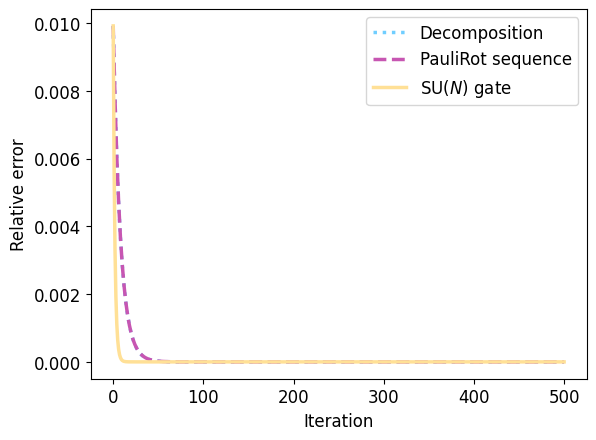

In [14]:
fig, ax = plt.subplots(1, 1)
styles = [":", "--", "-"]
colors = ["#70CEFF", "#C756B2", "#FFE096"]
for (name, energy), c, ls in zip(energies.items(), colors, styles):
    error = (energy - E_min) / abs(E_min)
    ax.plot(list(range(len(error))), error, label=name, c=c, ls=ls, lw=2.5)

ax.set(xlabel="Iteration", ylabel="Relative error")
ax.legend()
plt.show()